# Time series analysis - Example code 23: Estimating the unknown parameters of an ARMA process using the Kalman filter with missing samples

**Lund University, Lund, Sweden**

**Reference:**  
"An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')


from tsa_lth.analysis import plotACFnPACF, plotWithConf
from tsa_lth.tests import whiteness_test, check_if_normal

## Simulate a process

In [2]:
# Simulate a process.
np.random.seed(0)                                   # Set the seed (just done for the lecture!)
extraN = 100
N  = 1000
A0 = np.array([1, -0.95])
C0 = np.array([1, 0.5, 0, -0.2])
e  = np.random.randn(N + extraN)
y  = lfilter(C0, A0, e)
y = y[extraN:]
tt = np.arange(N)

In [3]:
# Insert missing samples, marked with NaN.
noNan = 30                                          # Number of missing samples.
noVal = np.random.randint(100, N-100, noNan)        # Lets stress the system a bit.
#noVal = np.random.randint(750, 850, noNan)
y0 = y.copy()                                       # Retain the original.
#y[noVal] = np.nan                                  # Replace missing samples.
y1 = y.copy()                                       # Replica to allow for modifications.

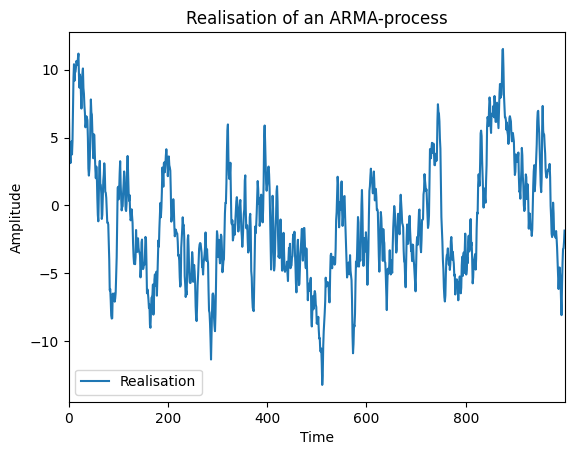

In [4]:
# Plot realisation.
plt.figure()
plt.plot(y)
plt.ylabel('Amplitude')
plt.xlabel('Time')
if np.sum(np.isnan(y)) > 0:
    plt.plot(tt[noVal], y0[noVal], 'r*', label='Missing sample')
    plt.legend(['Realisation', 'Missing sample'], loc='lower left')
    plt.title('Realisation of an ARMA-process with missing samples')
else:
    plt.legend(['Realisation'], loc='lower left')
    plt.title('Realisation of an ARMA-process')
plt.xlim([0, N-1])
plt.show()

## Lets form the one-step prediction using the Kalman filter

In [5]:
# Construct a Kalman filter that assumes the model parameters to be known.
# Note how this differs from the setup in code20, where the parameters
# where instead treated as unknown.
p0 = 1                                              # Number of unknowns in the A polynomial.
q0 = 2                                              # Number of unknowns in the C polynomial.

A     = np.eye(p0 + q0)
Rw    = 1                                           # Measurement noise covariance matrix, R_w. Note that Rw has the same dimension as Ry.
Re    = 1e-6 * np.eye(p0 + q0)                      # System noise covariance matrix, R_e. Note that Re has the same dimension as Rx_t1.
Rx_t1 = np.eye(p0 + q0)                             # Initial covariance matrix, R_{1|0}^{x,x}
h_et  = np.zeros(N)                                 # Estimated one-step prediction error.
xt    = np.zeros((p0 + q0, N))                      # Estimated states. Intial state, x_{1|0} = 0.
yhat  = np.zeros(N)                                 # Estimated output.
xStd  = np.zeros((p0 + q0, N))                      # Stores one std for the one-step prediction.
for t in range(3, N):                               # We use t-3, so start at t=4.
    # Update the predicted state and the time-varying state vector.
    x_t1 = A @ xt[:, t-1]                           # x_{t|t-1} = A x_{t-1|t-1}
    C    = np.array([[-y1[t-1], h_et[t-1], h_et[t-3]]])  # Use earlier prediction errors as estimate of e_t.
    
    # Update the parameter estimates.
    Ry = C @ Rx_t1 @ C.T + Rw                       # R_{t|t-1}^{y,y} = C R_{t|t-1}^{x,x} + Rw
    Kt = Rx_t1 @ C.T / Ry                           # K_t = R^{x,x}_{t|t-1} C^T inv( R_{t|t-1}^{y,y} )
    yhat[t] = (C @ x_t1)[0]                         # One-step prediction, \hat{y}_{t|t-1}.

    # If a sample is missing, just retain the earlier state.
    if np.isnan(y[t]):
        xt[:, t] = x_t1                             # x_{t|t} = x_{t|t-1}
        Rx_t    = Rx_t1                             # R^{x,x}_{t|t} = R^{x,x}_{t|t-1}
        y1[t]   = yhat[t]                           # Replace the missing sample with the estimated value.
    else:
        h_et[t] = y[t] - yhat[t]                    # One-step prediction error, \hat{e}_t = y_t - \hat{y}_{t|t-1}
        xt[:, t] = x_t1 + Kt[:, 0] * h_et[t]        # x_{t|t} = x_{t|t-1} + K_t ( y_t -  \hat{y}_{t|t-1} )
        Rx_t    = Rx_t1 - Kt @ Ry @ Kt.T            # R^{x,x}_{t|t} = R^{x,x}_{t|t-1} - K_t R_{t|t-1}^{y,y} K_t^T
    Rx_t1 = A @ Rx_t @ A.T + Re                     # R^{x,x}_{t+1|t} = A R^{x,x}_{t|t} A^T + Re

    # Estimate a one std confidence interval of the estimated parameters.
    xStd[:, t] = np.sqrt(np.diag(Rx_t))

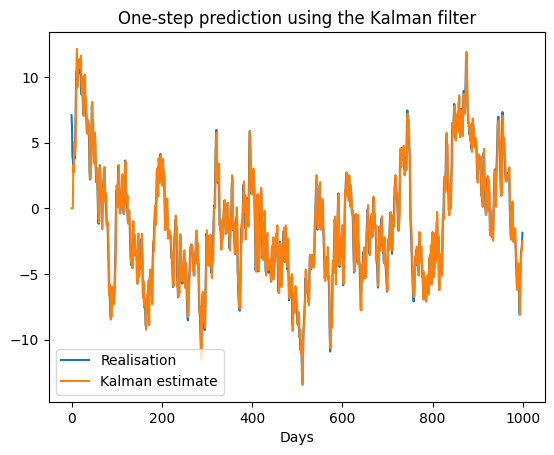

In [6]:
# Show the one-step prediction. We compare with y, not y1, as the former
# retains the missing samples (this was the reason to use the y1 vector);
# this is just to illustrate the missing samples in the figure.
plt.figure()
plt.plot(tt, y, label='Realisation')
plt.plot(tt, yhat, label='Kalman estimate')
plt.xlabel('Days')
if np.sum(np.isnan(y)) > 0:
    plt.plot(tt[noVal], y0[noVal], 'b*', label='Missing sample')
    plt.legend(loc='lower left')
    plt.title('One-step prediction using the Kalman filter with missing samples')
else:
    plt.legend(loc='lower left')
    plt.title('One-step prediction using the Kalman filter')
plt.show()

## Examine the estimated parameters

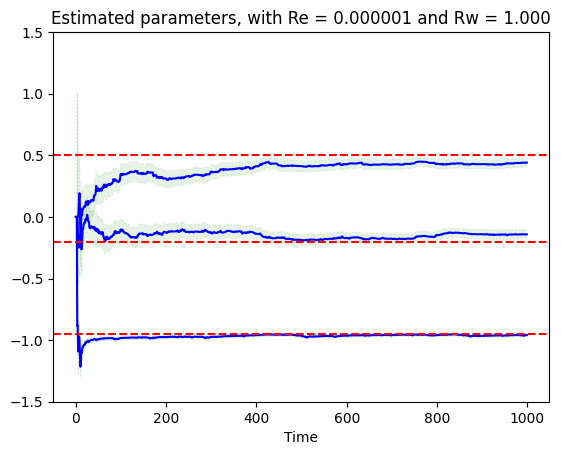

In [7]:
# Examine the estimated parameters.
trueParams = np.array([A0[1], C0[1], C0[3]])        # These are the true parameters we seek.
plt.figure()
plotWithConf(np.arange(N), xt.T, xStd.T, trueParams)
plt.title(f'Estimated parameters, with Re = {Re[0, 0]:.6f} and Rw = {Rw:.3f}')
plt.xlabel('Time')
plt.ylim([-1.5, 1.5])
plt.show()

In [8]:
# Examine the final predicted parameters.
print('The final values of the estimated parameters are:')
for k in range(len(trueParams)):
    print(f'  True value: {trueParams[k]:5.2f}, estimated value: {xt[k, -1]:5.2f} (+/- {xStd[k, -1]:5.4f}).')

The final values of the estimated parameters are:
  True value: -0.95, estimated value: -0.96 (+/- 0.0154).
  True value:  0.50, estimated value:  0.44 (+/- 0.0373).
  True value: -0.20, estimated value: -0.14 (+/- 0.0378).


## Examine one-step prediction residual

In [9]:
# Examine one-step prediction residual.
# Here, as an example, we condider the data from 600 to N as our validation
# data, and therefore extract just this part to compute the prediction residual.
ey = y0[599:N] - yhat[599:N]                        # Ignore the initial values to let the filter converge first.
whiteness_test(ey)

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 17.00 < 37.65)
  McLeod-Li test:        True (white if 18.20 < 37.65)
  Monti test:            True (white if 16.85 < 37.65)
  Sign change test:      True (white if 0.46 in [0.45,0.55])


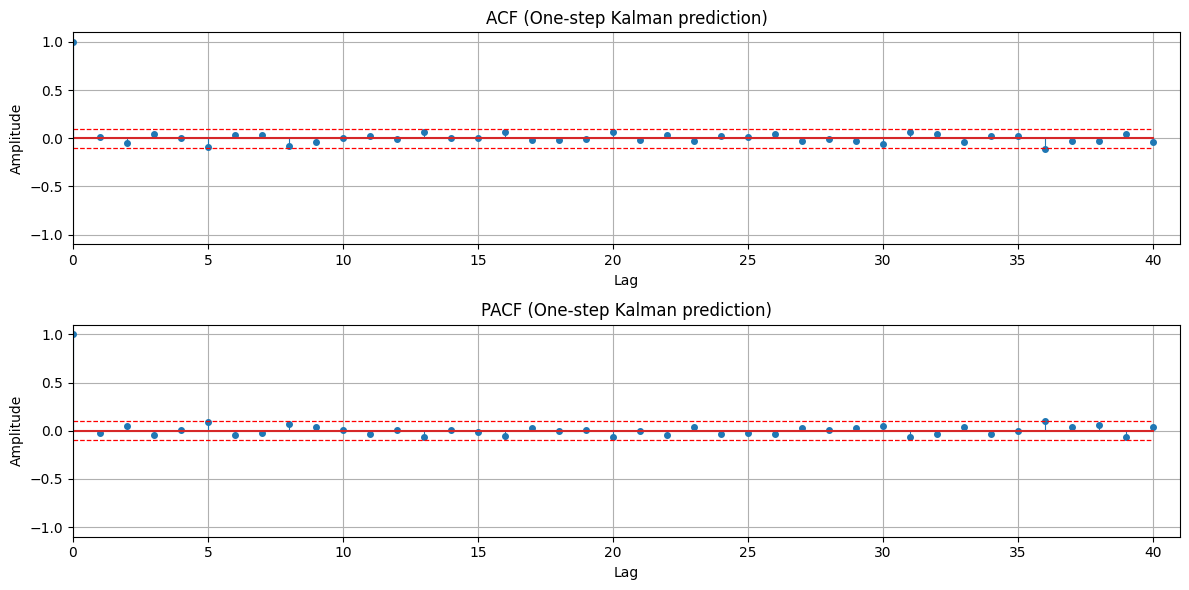

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


In [10]:
acfEst, pacfEst = plotACFnPACF(ey, 40, 'One-step Kalman prediction', return_val=True)
check_if_normal(pacfEst[1:], which_test='D', alpha=0.05)